<a href="https://colab.research.google.com/github/wisrovi/SAM/blob/master/Red%20Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Vamos a necesitar usar la GPU de la maquina
#####Entorno de ejecución/cambiar tipo de entorno de ejecución/acelerador por hardware / GPU
### Si Esto no se hace, no se podrá usar el reconocimiento facial


In [1]:
#instalamos las librerias que no vienen preinstaladas
!pip3 install dlib
!pip install cmake
!pip3 --no-cache-dir install face_recognition

     |████████████████████████████████| 100.2MB 41.0MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566176 sha256=5e1f19f14b29112a09fb2105d2915f905023728cf6342d3d35c3d2589765c817
  Stored in directory: /tmp/pip-ephem-wheel-cache-zok1xnld/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
#Confirmamos que la instalación haya sido exitosa
import dlib
import face_recognition

In [3]:
#asociamos nuestra cuenta de google para que el sistema guarde allí los archivos y datos que se procesaran

raiz = '/content/drive/'

#API google colab con google drive
from google.colab import drive
drive.mount(raiz)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
def verContenidoCarpeta():
  a = !ls "/content/drive/My Drive/Redes Neuronales"
  return a

In [5]:
a = verContenidoCarpeta()
if len(a)>0:
  if str(a[0]).index('cannot access') > 0:
    print("El directorio no existe, creando el directorio")
    !mkdir "/content/drive/My Drive/Redes Neuronales"
else:
  print("El directorio esta vacio")

El directorio esta vacio


In [6]:
verContenidoCarpeta()

[]

In [7]:
def descargarArchivos():
  !git clone https://github.com/wisrovi/SAM "/content/drive/My Drive/Redes Neuronales"

descargarArchivos()

fatal: destination path '/content/drive/My Drive/Redes Neuronales' already exists and is not an empty directory.


In [8]:
verContenidoCarpeta()

[]

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image

<IPython.core.display.Javascript object>

Saved to wisrovi.jpg


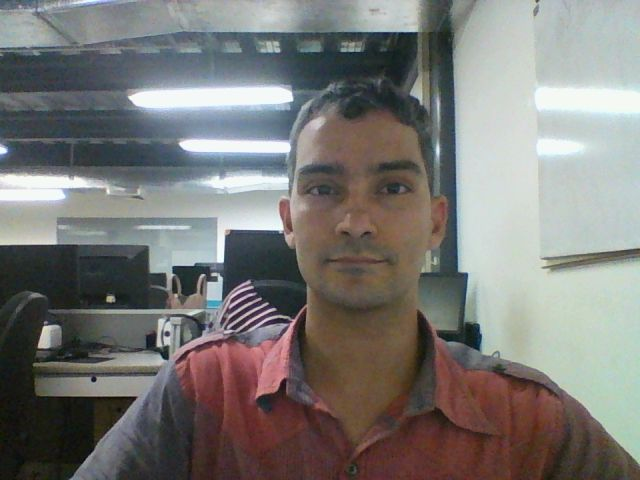

In [11]:
nombreGuardarImagen = "wisrovi.jpg"
def TomarGuardarFoto():
  try:
    filename = take_photo(nombreGuardarImagen)
    print('Saved to {}'.format(filename))
    display(Image(filename))
  except Exception as err:
    print(str(err))
    
TomarGuardarFoto()

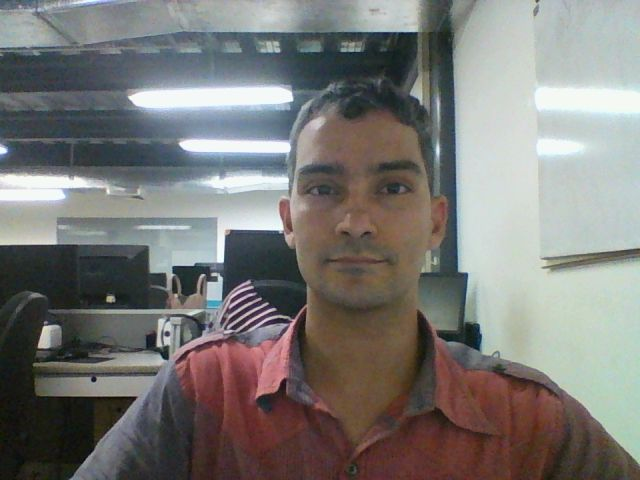

In [12]:
#confirmamos que la foto se guardo y la podremos usar mas adelante

from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(nombreGuardarImagen, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [14]:
#Cargamos los archivos:
#deploy.prototxt.txt -> Estructura de la red neuronal
#res10_300x300_ssd_iter_140000.caffemodel -> Pesos de la red neuronal
#Libreria que configura y usa la red neuronal

from google.colab import files
files.upload()

#Esta red neuronal fue entrenada por: thegopieffect y las fuentes originales estan en:
#https://github.com/thegopieffect/computer_vision/tree/master/CAFFE_DNN

Saving deploy.prototxt.txt to deploy.prototxt.txt
Saving OpenCV_3.py to OpenCV_3.py
Saving res10_300x300_ssd_iter_140000.caffemodel to res10_300x300_ssd_iter_140000.caffemodel


In [0]:
#Cargamos la red neuronal de deteccion de rostros
#si bien OpenCV tiene un Haarscade para la detección, esta no es muy rápida y ademas en el menor angulo de inclinación de rostros deja de detectar
from OpenCV_3 import OpenCV_3
detecFaces = OpenCV_3()
detecFaces.setConfianzaDeteccion(0.40)

In [0]:
#Cargamos la imagen en una variable usando OpenCv
frame = cv2.imread(nombreGuardarImagen, cv2.IMREAD_COLOR)

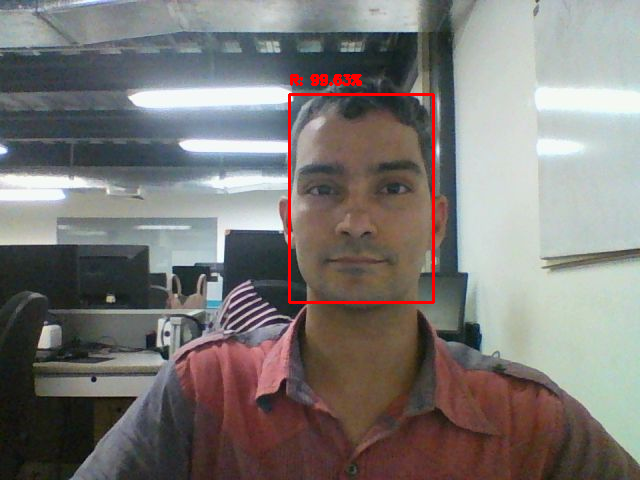

In [17]:
#Buscamos los rostros y dibujamos un recuadro alrededor del rostro, ademas indicamos el porcentaje de detección de la red neuronal

listadoCoordenadasRostros = detecFaces.detectarRostros(frame)
for (startX, startY, endX, endY, confianzaEsteRostro) in listadoCoordenadasRostros:
  cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)

  text = "R: " + "{:.2f}%".format(confianzaEsteRostro * 100)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

  rostroColor = frame[startY:endY, startX:endX]
cv2_imshow(frame)

In [18]:
import face_recognition
image = face_recognition.load_image_file(nombreGuardarImagen)
face_locations = face_recognition.face_locations(image)
print("Cara encontrada en: ", face_locations)

Cara encontrada en:  [(150, 442, 305, 287)]


## Ahora vamos a extraer los puntos caracteristicos

<img src="https://lh3.googleusercontent.com/-_qd-G1852mU/WgRYbIKNbaI/AAAAAAAADzg/FvnCvaLfctgmjBphMAD44O61Hhxl0e3_wCHMYCw/facial_landmarks_68markup_thumb?imgmax=800" width="600">

### Miremos los puntos encontrados

In [19]:
face_landmarks_list = face_recognition.face_landmarks(image)

categoriaPuntos = [
    "chin",
    "left_eyebrow",
    "right_eyebrow",
    "nose_bridge",
    "nose_tip",
    "left_eye",
    "right_eye",
    "top_lip",
    "bottom_lip"
]

diccionarioPuntos = face_landmarks_list[0]
for categoria in range(len(categoriaPuntos)):
  categoriaPuntos[categoria]
  print("Categoria: ", end="")
  print(categoriaPuntos[categoria], end=" \t ")
  print("Puntos encontrados:", end="")
  print(diccionarioPuntos[categoriaPuntos[categoria]])

Categoria: chin 	 Puntos encontrados:[(289, 195), (291, 215), (293, 233), (296, 252), (301, 270), (309, 285), (322, 296), (338, 305), (358, 308), (377, 306), (396, 297), (412, 287), (424, 272), (430, 255), (434, 236), (438, 216), (441, 196)]
Categoria: left_eyebrow 	 Puntos encontrados:[(295, 178), (304, 167), (318, 163), (333, 164), (348, 170)]
Categoria: right_eyebrow 	 Puntos encontrados:[(367, 168), (383, 162), (398, 160), (414, 163), (424, 175)]
Categoria: nose_bridge 	 Puntos encontrados:[(358, 186), (357, 199), (356, 212), (355, 225)]
Categoria: nose_tip 	 Puntos encontrados:[(341, 236), (348, 239), (356, 241), (364, 239), (372, 237)]
Categoria: left_eye 	 Puntos encontrados:[(310, 191), (319, 186), (329, 186), (339, 194), (329, 195), (318, 195)]
Categoria: right_eye 	 Puntos encontrados:[(378, 193), (388, 185), (398, 184), (407, 190), (399, 194), (388, 194)]
Categoria: top_lip 	 Puntos encontrados:[(327, 261), (338, 258), (348, 256), (355, 258), (363, 257), (373, 259), (387, 26

### Ahora codifiquemos estos datos para que no sean tan trasparentes, esto se hace para la protección de los datos

#### Con esto tendremos los datos en una plantilla unica de caracteristicas

In [0]:
def ExtraerVectorCaractersticas(nombreArchivo):
  image = face_recognition.load_image_file(nombreArchivo)
  person_encoding = face_recognition.face_encodings(image)[0]
  return person_encoding

In [21]:
vectorPersonaConocida = ExtraerVectorCaractersticas(nombreGuardarImagen)
print("Vector de caracteristicas: ", vectorPersonaConocida)

Vector de caracteristicas:  [-0.15058479  0.2157817   0.00431588 -0.05734204 -0.0512614  -0.01778315
 -0.02170319 -0.04717222  0.2281231  -0.06474786  0.20032361 -0.03192602
 -0.18959884 -0.09123418 -0.118893    0.1314408  -0.18337166 -0.16693889
 -0.10556464 -0.07410361  0.04349034  0.14345565 -0.03393574  0.04272219
 -0.12229046 -0.32083857 -0.06262874 -0.13230516 -0.01816887 -0.13460124
 -0.01253425  0.03662622 -0.10555664 -0.05906985  0.03749143  0.11186059
 -0.0314865  -0.06517565  0.24254508  0.05245712 -0.1327412  -0.02444566
  0.08907413  0.41470641  0.18073957 -0.06483302  0.00155001 -0.08897372
  0.16866978 -0.19406438  0.04663257  0.18102996  0.11614777  0.07713265
  0.14950031 -0.09655957 -0.00998589  0.1229485  -0.19439767  0.00146024
  0.0326703  -0.07119264 -0.05464531 -0.05656752  0.19104964  0.10851394
 -0.08455089 -0.10165223  0.22292614 -0.13704789 -0.05756941  0.04908811
 -0.07805444 -0.15050952 -0.2412491   0.03727045  0.46915969  0.12365399
 -0.13866319  0.0682121

#### Con este vector almacenado en una base de datos, ya podremos guardar los datos de la persona (sin guardar la imagen) y podremos consultar el vector cuando se requiera y compararlo con otro vector para ver si es la misma persona.

In [0]:
#Creamos un vector con las personas conocidas (Nota: debe ser un vector)
personasConocidas = [
    vectorPersonaConocida
]

#Creamos tambien un vector con los nombres de las personas
nombrePersona = [
    "WISROVI"
]

<IPython.core.display.Javascript object>

Saved to desconocido.jpg


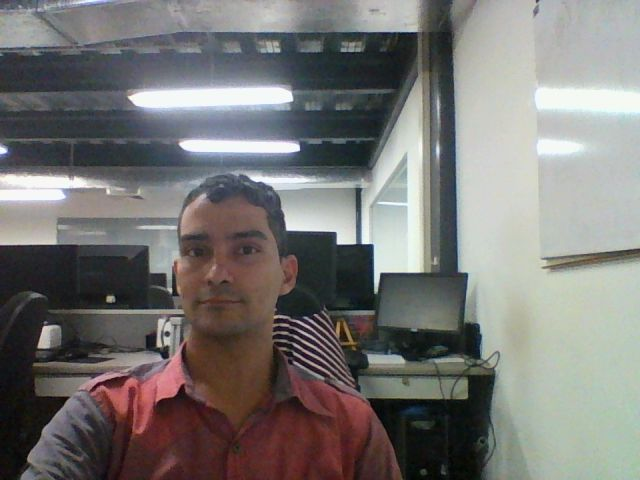

In [23]:
#Tomemos una nueva foto
nombreGuardarImagen = "desconocido.jpg"
TomarGuardarFoto()

In [0]:
#Hallamos el vector del nuevo rostro
unknown_image = face_recognition.load_image_file(nombreGuardarImagen)
vector_persona_desconocida = face_recognition.face_encodings(unknown_image)[0]

In [25]:
#Ahora vamos a buscar este nuevo vector entre los rostros ya conocidos
results = face_recognition.compare_faces(personasConocidas, vector_persona_desconocida)
vector_respuesta_persona_reconocida_segun_lista_personasConocidas = results
print(vector_respuesta_persona_reconocida_segun_lista_personasConocidas)

[True]


In [26]:
#Pero como un vector de detección no es algo legible para el usuario, debemos convertir ese vector en el nombre
def TraducirVectorRespuestaEnNombre(vector):
  if True in vector:
    indice = vector.index(True)  
    return nombrePersona[indice]
    
    
nombrePersonaFrenteCamara = TraducirVectorRespuestaEnNombre(vector_respuesta_persona_reconocida_segun_lista_personasConocidas)
print("La persona frente a la cámara es: ", nombrePersonaFrenteCamara)

La persona frente a la cámara es:  WISROVI


### Borrar el directorio y su contenido del drive, esto en caso de que no se quiera conservar la información

In [0]:
try:
  !rm -r "/content/drive/My Drive/Redes Neuronales"
except:
  pass